Team: Samuel Lokadjaja (Externe Teilnahme)

In [1]:
!pip install ta
!pip install xgboost
!pip install scikit-learn
!pip install tqdm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

**Get data**

In [3]:
btc_hourly = pd.read_csv("btc_1h.csv")
btc_hourly.head()

,date,1a. open (EUR),2a. high (EUR),3a. low (EUR),4a. close (EUR),5. volume
0,2023-05-02 04:00:00,25603.01,25609.98,25484.00,25492.00,19.03654
1,2023-05-02 05:00:00,25495.00,25576.05,25447.36,25571.33,26.65223
2,2023-05-02 06:00:00,25571.33,25596.93,25539.00,25561.01,23.76945
3,2023-05-02 07:00:00,25561.01,25684.91,25549.02,25625.99,43.66961
4,2023-05-02 08:00:00,25626.48,25728.33,25590.81,25614.61,43.87288


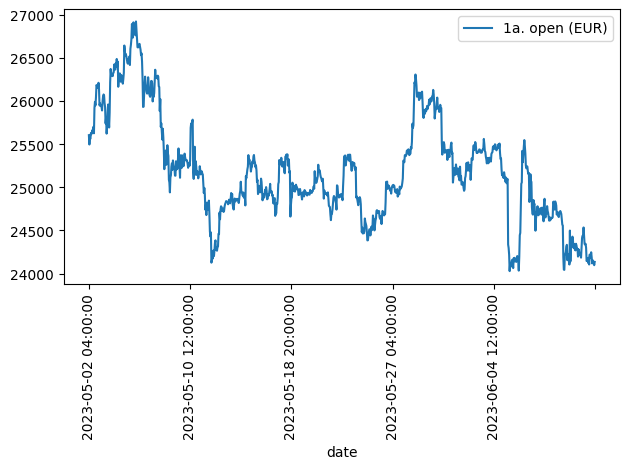

In [4]:
fig, ax = plt.subplots()
btc_hourly.plot(x="date", y="1a. open (EUR)", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

In [5]:
btc_hourly.columns

Index(['date', '1a. open (EUR)', '2a. high (EUR)', '3a. low (EUR)',
       '4a. close (EUR)', '5. volume'],
      dtype='object')

**Calculate returns**

In [6]:
rets = btc_hourly['4a. close (EUR)'].pct_change().shift(-1)
rets.head()

0    0.003112
1   -0.000404
2    0.002542
3   -0.000444
4    0.000875
Name: 4a. close (EUR), dtype: float64

**Define trading signal**

In [7]:
from ta.volume import OnBalanceVolumeIndicator
from ta.momentum import RSIIndicator, ROCIndicator, WilliamsRIndicator
from ta.trend import SMAIndicator, MACD
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
import numpy as np

In [8]:
def ma_crossover(close, short_period, long_period):
    short = SMAIndicator(close=close, window=short_period).sma_indicator()
    long = SMAIndicator(close=close, window=long_period).sma_indicator()

    return short - long

In [9]:
# Define parameters for technical indicators
ma_crossover_arr = [(1, 50), (1, 200), (5, 200), (2, 200), (1, 150)]
roc_arr = [25, 50, 100]
rsi_arr = [50, 100, 150]
swr_arr = [14, 20, 50]


def signal(df):
    window_rets = df['4a. close (EUR)'].pct_change().shift(-1)

    features = pd.DataFrame()

    # Compute technical indicators
    features['obv'] = OnBalanceVolumeIndicator(close=df['4a. close (EUR)'], volume=df['5. volume']).on_balance_volume()
    features['macd'] = MACD(df['4a. close (EUR)']).macd_signal()

    for idx, ma in enumerate(ma_crossover_arr):
        features[f'ma_crossover_{idx}'] = ma_crossover(df['4a. close (EUR)'], *ma)

    for roc in roc_arr:
        features[f'roc_{roc}'] = ROCIndicator(close=df['4a. close (EUR)'], window=roc).roc()

    for rsi in rsi_arr:
        features[f'rsi_{rsi}'] = RSIIndicator(close=df['4a. close (EUR)'], window=rsi).rsi()

    for swr in swr_arr:
        features[f'swr_{swr}'] = WilliamsRIndicator(high=df['2a. high (EUR)'],
                                                    low=df['3a. low (EUR)'],
                                                    close=df['4a. close (EUR)'],
                                                    lbp=swr).williams_r()

    features['target'] = window_rets
    features['target_cls'] = (features['target'] > 0).astype(int)

    X_last = features.iloc[[-1]].drop(labels=['target', 'target_cls'], axis=1)

    features = features.dropna()

    X = features.drop(columns=['target', 'target_cls'])
    y = features['target']
    y_cls = features['target_cls']

    # Train model
    reg = LinearRegression().fit(X, y)
    pred = reg.predict(X_last)

    if pred > 0:
        return 1
    else:
        return 0

**Backtest**

In [10]:
window_size = 500
iters = len(btc_hourly) - window_size

signal_arr = []
for i in tqdm(range(iters)):
    curr_data = btc_hourly.iloc[i:i + window_size, :]
    signal_arr.append(signal(curr_data))

# Compute returns
signals = pd.Series(signal_arr)
realized_rets = signals * rets[window_size:].reset_index(drop=True)
realized_rets = realized_rets.dropna()

# Transaction costs
tcost = 0.0005  # 5 bps
turnover = signals - pd.Series([0] + signal_arr[:-1])
turnover = turnover.abs()

realized_rets = realized_rets - turnover * tcost

100%|██████████| 500/500 [00:04<00:00, 117.56it/s]


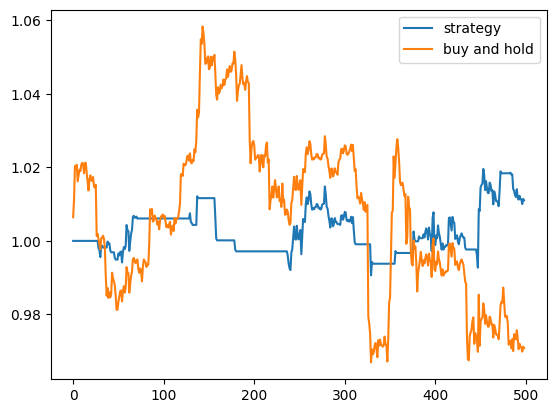

In [11]:
fig, ax = plt.subplots()

ax.plot((realized_rets + 1).cumprod(), label="strategy")
ax.plot((rets[window_size:].reset_index(drop=True) + 1).cumprod(), label="buy and hold")
ax.legend()

plt.show()

**Metrics**

In [12]:
cumulative_return = ((realized_rets + 1).prod() - 1) * 100
mean_return = ((1 + realized_rets.mean()) ** 8760 - 1) * 100  # 8760 hours in 1 year
vola = realized_rets.std() * np.sqrt(8760) * 100
sharpe_ratio = mean_return / vola

print(
    f"Cumulative return: {cumulative_return:.2F}% \nMean return (annualized): {mean_return:.2F}% \nVolatility (annualized): {vola:.2F}% \nSharpe ratio: {sharpe_ratio:.2F}")

Cumulative return: 1.10% 
Mean return (annualized): 22.92% 
Volatility (annualized): 16.67% 
Sharpe ratio: 1.37


**Define bot**

In [13]:
def bot(df):
    sig = signal(df)

    if sig == 1:
        return "BTC"
    else:
        return "EUR"

**Todos**

- Analyze performance in detail (mse loss, precision/recall)
- EDA
- Use ensembles?
- How to reduce turnover?
- Add more technical indicators?